## 4. Neural Networks Learning in Theano

The aim of this IPython notebook is to show some features of the Python **Theano** library in the field of machine learning. It has been developped by the LISA group at the *University of Montreal* (see: http://deeplearning.net/software/theano/). The notebook also relies on other standard Python libraries such as *numpy*, *pandas* and *matplotlib*.

To exemplify the use of **Theano**, this notebook solves the assignments of the *Machine Learning* MOOC provided by **Coursera** (see: https://www.coursera.org/learn/machine-learning) and performed in *Stanford University* by **Andrew Ng** (see: http://www.andrewng.org/).

The original MOOC assignments should to be programmed with the **Octave** language (see: https://www.gnu.org/software/octave/).The idea with this notebook is to provide Python developpers with interesting examples programmed using **Theano**.

This notebook has been developped using the *Anaconda* Python 3.4 distribution provided by **Continuum Analytics** (see: https://www.continuum.io/). It requires the **Jupyter Notebook** (see: http://jupyter.org/).

About the author: **Francis Wolinski** has an Engineering Degree From *Ecole des Ponts ParisTech* as well as a MSc. in Artificial Intelligence and a PhD. in Computer Science from *Université Pierre et Marie Curie* (UPMC).


### 4.1 Neural Networks

#### 4.1.1 Visualizing the data

In [1]:
import theano
import numpy as np
import theano.tensor as T
from theano.tensor.nnet import sigmoid
import scipy.io as sio
data = sio.loadmat('data/ex4data1.mat')
X, Y = data['X'], data['y'].T[0]
m = X.shape[0]

In [2]:
%matplotlib inline
import pandas as pnd
import matplotlib.pyplot as plt

def display_data(X, Y):
    example_width = int(np.sqrt(X.shape[1]))

    # Compute rows, cols
    m, n = X.shape
    example_height = int(n / example_width)

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    # Between images padding
    pad = 1

    # Setup blank display
    display_array = - np.ones((pad + display_rows * (example_height + pad),\
                           pad + display_cols * (example_width + pad)))

    # Copy each example into a patch on the display array
    # dataset contains 20 pixel by 20 pixel grayscale images of the digit 
    curr_ex = 0
    for j in range(display_rows):
        for i in range(display_cols):
            if curr_ex >= m:
                break
            # Get the max value of the patch
            max_val = max(abs(X[curr_ex]))
            display_array[(pad + j * (example_height + pad)):(pad + j * (example_height + pad))+example_height,\
                          (pad + i * (example_width + pad)):(pad + i * (example_width + pad))+example_width] =\
                            np.reshape(X[curr_ex], (example_height, example_width)) / max_val
            curr_ex += 1
        if curr_ex >= m:
            break 

    plt.figure(figsize=(8,6))
    plt.axis('off')
    plt.imshow(display_array.T, cmap="Greys_r")
    
    df = pnd.DataFrame(Y.reshape((display_rows, display_cols)).T)
    df = df.replace(10,0) # 0 is mapped to 10 in Y
    print(df)

   0  1  2  3  4  5  6  7  8  9
0  1  4  4  2  4  3  9  4  2  1
1  7  5  4  6  3  9  5  9  7  1
2  9  0  8  6  0  4  2  3  3  2
3  8  1  0  8  4  2  7  5  4  5
4  3  1  6  8  1  6  4  7  0  1
5  4  2  2  5  8  0  7  4  4  0
6  9  9  9  1  0  5  3  4  1  6
7  5  6  2  7  1  4  5  4  4  3
8  8  9  3  8  7  5  0  6  4  2
9  9  5  5  5  2  7  7  0  3  8


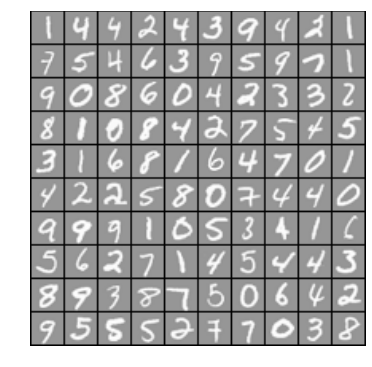

In [3]:
rnd = np.random.permutation(m)[0:100]
sel = X[rnd,:] # 100 random digits
res = Y[rnd]
display_data(sel, res)

#### 4.1.2 Feedforward and cost function

In [4]:
def T_add_ones(x, a, b):
    var = T.concatenate([T.ones(a), x.flatten().T])
    return var.reshape((b, a))

X1 = np.c_[np.ones(m), X] # Add intercept term to X
X1 = X1.T

# load precomputed network parameters
weights = sio.loadmat('data/ex4weights.mat')
t1 = weights['Theta1']
t2 = weights['Theta2']

print("X1:", X1.shape)
print("theta1:", t1.shape)
print("theta2:", t2.shape)

# layer sizes
input_layer_size = X.shape[1]
hidden_layer_size = t1.shape[0]
num_labels = t2.shape[0]

print('\ninput_layer_size: %i' % input_layer_size)
print('hidden_layer_size: %i' % hidden_layer_size)
print('num_labels: %i' % num_labels)

x = T.matrix('x')
y = T.vector('y')
theta1 = theano.shared(t1, 'theta1')
theta2 = theano.shared(t2, 'theta2')

# first layer
y1 = sigmoid(T.dot(theta1, x))

# second layer
y2 = T_add_ones(y1, m, hidden_layer_size+1)
y3 = sigmoid(T.dot(theta2, y2))

J = 0
for i in range(num_labels):
    yy = T.eq(y,i+1)
    J += -T.sum(yy * T.log(y3[i,:]) + (1 - yy) * T.log(1 - y3[i,:])) / m

cost = theano.function([x, y], J)

print('\ncost: %f' % cost(X1, Y))

X1: (401, 5000)
theta1: (25, 401)
theta2: (10, 26)

input_layer_size: 400
hidden_layer_size: 25
num_labels: 10

cost: 0.287629


#### 4.1.3 Regularized cost function

In [5]:
# Weight regularization parameter (we set this to 0 here).
lambda_ = 1

x = T.matrix('x')
y = T.vector('y')
theta1 = theano.shared(t1, 'theta1')
theta2 = theano.shared(t2, 'theta2')

# first layer
y1 = sigmoid(T.dot(theta1, x))

# second layer
y2 = T_add_ones(y1, m, hidden_layer_size+1)
y3 = sigmoid(T.dot(theta2, y2))

# regularization on theta1 and theta2
reg = lambda_ * (T.sum(theta1[:,1:]**2) + T.sum(theta2[:,1:]**2)) / 2 / m
J = reg
for i in range(num_labels):
    yy = T.eq(y,i+1)
    J += -T.sum(yy * T.log(y3[i,:]) + (1 - yy) * T.log(1 - y3[i,:])) / m
  
cost = theano.function([x, y], J)
    
print('cost: %f' % cost(X1, Y))

cost: 0.383770


## 4.2 Backpropagation

### 4.2.1 Sigmoid gradient

In [6]:
x = T.matrix('x')
h = 1.0 / (1.0 + T.exp(-x))
h_grad = h * (1-h)

sigmoid2 = theano.function([x], h)
sigmoid2_grad = theano.function([x], h*(1-h))
print(sigmoid2(np.array([[-1, -0.5, 0, 0.5, 1]])))
print(sigmoid2_grad(np.array([[-1, -0.5, 0, 0.5, 1]])))

[[ 0.26894142  0.37754067  0.5         0.62245933  0.73105858]]
[[ 0.19661193  0.23500371  0.25        0.23500371  0.19661193]]


### 4.2.2 Random initialization

In [7]:
def rand_initialize_weights(l_in, l_out, epsilon_init):
    return np.random.rand(l_out, l_in+1) * 2 * epsilon_init - epsilon_init

epsilon_init = 0.12
t1 = rand_initialize_weights(input_layer_size, hidden_layer_size, epsilon_init)
t2 = rand_initialize_weights(hidden_layer_size, num_labels, epsilon_init)
t = np.concatenate([t1.flatten(), t2.flatten()])

### 4.2.3 Backpropagation

In [8]:
def T_add_ones(x, a, b):
    var = T.concatenate([T.ones(a), x.flatten().T])
    return var.reshape((b, a))

theta = theano.shared(t, 'theta')

# Choose some alpha value
alpha = 1

x = T.matrix('x')
y = T.vector('y')

# first layer
theta1 = theta[:t1.shape[0]*t1.shape[1]]
theta1 = theta1.reshape((t1.shape[0],t1.shape[1]))
y1 = sigmoid(T.dot(theta1, x))

# second layer
y2 = T_add_ones(y1, m, hidden_layer_size+1)
theta2 = theta[t1.shape[0]*t1.shape[1]:]
theta2 = theta2.reshape((t2.shape[0],t2.shape[1]))
y3 = sigmoid(T.dot(theta2, y2))

J = 0
for i in range(num_labels):
    yy = T.eq(y,i+1)
    J += -T.sum(yy * T.log(y3[i,:]) + (1 - yy) * T.log(1 - y3[i,:])) / m

grad = T.grad(J, theta)

train = theano.function([x,y], [J, y3], updates = [(theta, theta-alpha*grad)])

for i in range(2000):
    costM, y3 = train(X1,Y)
    if i%500 == 0:
        print('[%i] %f' % (i, costM))

print('cost: %f' % costM)

[0] 6.944886
[500] 0.474386
[1000] 0.332647
[1500] 0.259193
cost: 0.211194


In [9]:
# number of positive predictions where best prediction == Y-1
accuracy = np.sum(np.argmax(y3, axis=0) == (Y-1))/len(Y)
print('Train Accuracy: %f' % accuracy)

Train Accuracy: 0.978000


### 4.2.4 Regularized Neural Networks

In [12]:
theta = theano.shared(t, 'theta')

# Weight regularization parameter (we set this to 0 here).
lambda_ = 3

# Choose some alpha value
alpha = 1

# Weight regularization parameter (we set this to 0 here).
lambda_ = 1

x = T.matrix('x')
y = T.vector('y')

# first layer
theta1 = theta[:t1.shape[0]*t1.shape[1]]
theta1 = theta1.reshape((t1.shape[0],t1.shape[1]))
y1 = sigmoid(T.dot(theta1,x))

# second layer
y2 = T_add_ones(y1, m, hidden_layer_size+1)
theta2 = theta[t1.shape[0]*t1.shape[1]:]
theta2 = theta2.reshape((t2.shape[0],t2.shape[1]))
y3 = sigmoid(T.dot(theta2, y2))

# regularization on theta1 and theta2
reg = lambda_ * (T.sum(theta1[:,1:]**2) + T.sum(theta2[:,1:]**2)) / 2 / m

J = reg
for i in range(num_labels):
    yy = T.eq(y,i+1)
    J += -T.sum(yy * T.log(y3[i,:]) + (1 - yy) * T.log(1 - y3[i,:])) / m

grad = T.grad(J, theta)

train = theano.function([x,y], [J, y3], updates = [(theta, theta-alpha*grad)])

for i in range(2000):
    costM, y3 = train(X1,Y)
    if i%500 == 0:
        print('[%i] %f' % (i, costM))
        
print('cost: %f' % costM)

[0] 6.949777
[500] 0.560771
[1000] 0.457988
[1500] 0.414050
cost: 0.390036


In [11]:
# number of positive predictions where best prediction == Y-1
accuracy = np.sum(np.argmax(y3, axis=0) == (Y-1))/len(Y)
print('Train Accuracy: %f' % accuracy)

Train Accuracy: 0.973200
